<a href="https://colab.research.google.com/github/tomassams/tdt4173-machine-learning-project/blob/main/project_notebook_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


----

<div align="center">

<p align="center">

<h1> TDT4173 Project Assignment </h1>


<h1> A comparison of KNN and CNN for image classification in the gastrointestinal tract</h1>

<h2> CNN Implementation </h2>

</p>

</div>

----


*TDT4173 Machine Learning - NTNU, Fall 2020*

This notebook is one of two notebooks containing code used in the group project assignment. It is intended for use in Google Colab, and should run without issues there. However, most cells and commands can likely also run locally with minor adjustments. Things like CLI commands in the beginning (wget, unzip, etc) might be different based on your operating system.

The dataset used is the [Kvasir](https://datasets.simula.no/kvasir/) v2 dataset, containing classified images from the gastrointestinal tract.

Note that some parts are computation heavy - e.g. model training in this notebook, and is preferably ran with GPU support. Colab environments are provided with GPU resources, this can be set in "Runtime => Change runtime type" in the top menu.

## 1 Setup and prerequisites

If any of these imports return an error, you might have to install them with pip. It can be done in the command line, or by executing it in a notebook code cell. An export of the environment requirements can be found in **requirements.txt**.

In [ ]:
"""

    If the notebook is running in Colab, we want to download models and results
    when they are ready so they don't get lost if Colab times out.

    This global variable keeps track of that.

"""
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import files

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
"""

    Verify we are running the correct Tensorflow version

"""
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
"""

    Verify that we are using a GPU runtime

    If there is no GPU found, you can activate this in the Colab settings at "Runtime => Change runtime type".
    If you are running this locally, GPU support might require setup of CUDA/CUDNN beforehand.

    It is highly recommended to use a GPU while training the CNN models.

"""
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
"""

    Set up our project folder structure

"""
def create_folder_unless_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_folder_unless_exists('data/raw')
create_folder_unless_exists('data/zip')
create_folder_unless_exists('models')
create_folder_unless_exists('results/cnn_simple')
create_folder_unless_exists('results/cnn_resnet_tl')
create_folder_unless_exists('results/cnn_resnet_tl_tuned')

In [ ]:
"""

    Download and unzip the dataset

    1. Downloads the zip-file with wget
    2. Unzips it into the root folder
    3. Moves it into the ./data/raw/ folder
    4. Moves the original zip file to the ./data/zip/ folder

    If you are not running in a Colab environment, you might need to do this manually.

    Folder structure should look like this after:

    |-- project root
    |   |--> ...
    |   |--> ...
    |   |--> data
    |        |--> zip
    |             |--> kvasir-dataset-v2.zip
    |        |--> raw
    |             |--> dyed-lifted-polyps
    |             |--> dyed-resection-margins
    |             |--> esophagitis
    |             |--> normal-cecum
    |             |--> normal-pylorus
    |             |--> normal-z-line
    |             |--> polyps
    |             |--> ulcerative-colitis

"""
!wget "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip"
!unzip -qq kvasir-dataset-v2.zip
!cp kvasir-dataset-v2/* data/raw -r
!cp kvasir-dataset-v2.zip data/zip -r
!rm kvasir-dataset-v2 -rf
!rm kvasir-dataset-v2.zip

--2020-11-14 13:33:59--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  13.3MB/s    in 2m 42s  

2020-11-14 13:36:42 (14.7 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



In [ ]:
"""

    A helper utility to generate a pretty confusion matrix

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

"""
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save_path=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    plt.colorbar()
    plt.rcParams.update({'font.size': 18})


    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=18, ha="right")
        plt.yticks(tick_marks, target_names, fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.autoscale()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

In [ ]:
"""

    Utility function to plot, save and download the confusion matrix

"""
def display_confusion_matrix(y_pred, y_true, target_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, target_names, normalize=False, save_path=save_path)

    if RunningInCOLAB and save_path:
        files.download(save_path)

"""

    Utility function to print, save and download the classification report

"""
def display_classification_report(y_pred, y_true, target_names, save_path=None):
    cr = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    
    df = pd.DataFrame(cr).transpose()
    df = df.round(2)

    print(df)
    
    if save_path:
        df.to_csv(save_path, sep=';')
    
    if RunningInCOLAB and save_path:
        files.download(save_path)

In [ ]:
"""

    Simple helper utility to plot training history metrics against validation

"""
def plot_history(history):

    # loss vs val_loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='right')
    plt.show()

    # acc vs val_acc
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='right')
    plt.show()

In [ ]:
"""

    Even though Keras has provided an ImageDataGenerator which contains a 
    train/validation splitter, we actually want a train/validation/test split, 
    so lets do this manually.
    
"""
def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

def split_image_dataset(raw_path, processed_path, split_ratio):
    # make a copy from raw to processed
    shutil.copytree(raw_path, processed_path)

    # split files into train/test inside processed
    train_path = os.path.join(processed_path, 'train')
    test_path = os.path.join(processed_path,'test')

    # get dirs
    _, dirs, _ = next(os.walk(processed_path))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(processed_path, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - split_ratio))

    print(f"Total data per class: {data_counter_per_class}")
    print(f"Test instances per class: {test_counter}")

    # transfers files
    for i in range(len(dirs)):
        files = get_files_from_folder(os.path.join(processed_path, dirs[i]))
        train_path = os.path.join(processed_path, 'train' ,dirs[i])
        test_path = os.path.join(processed_path, 'test' ,dirs[i])

        if not os.path.exists(train_path):
            os.makedirs(train_path)
        if not os.path.exists(test_path):
            os.makedirs(test_path)
        
        # moves data
        for j in range(int(data_counter_per_class[i])):
            src = os.path.join(processed_path, dirs[i], files[j])
            if j < test_counter[i]:
                dst = os.path.join(processed_path, 'test', dirs[i], files[j])
            else:
                dst = os.path.join(processed_path, 'train', dirs[i], files[j])
            shutil.move(src, dst)

        os.removedirs(os.path.join(processed_path, dirs[i]))

In [ ]:
"""
    Split the dataset into 80/20 train/test and put it into 'data/processed'
"""
split_image_dataset('data/raw', 'data/processed', split_ratio=0.80)

Total data per class: [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
Test instances per class: [200. 200. 200. 200. 200. 200. 200. 200.]


In [ ]:
"""
    Parameters that apply for all models and datagenerators
"""
train_path = 'data/processed/train'
test_path = 'data/processed/test'
batch_size = 32

target_w = 256
target_h = 256
target_size = (target_w, target_h) 
target_dims = 3 # (RGB channels)

## 2 Convolutional Neural Network

### 2.1 Preprocessing

In [ ]:
"""

    Set up datagenerators for CNN model

    Datagenerators handle image augmentation (shear, zoom, horizontal flips) as well as rescaling.
    The datagenerator also has a built-in training/validation splitter, which creates a new 80/20 split.

    In addition to that, we want a separate generator with our test set.

    The dataset will be split as follows:
    - Training set (64% - 80% of 80)
    - Validation set (16% - 20% of 80)
    - Test set (20%)

"""

"""
    Datagenerator for training set
"""
cnn_train_idg = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # If defined, will split based on 'subset' in flow_from_directory()

cnn_train_datagen = cnn_train_idg.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    subset='training') # Marks this as the training data

cnn_val_datagen = cnn_train_idg.flow_from_directory(
    train_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    subset='validation') # Marks this as the validation data

"""
    Datagenerator for test set
"""
cnn_test_idg = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

cnn_test_datagen = cnn_test_idg.flow_from_directory(
    test_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False)

Found 5120 images belonging to 8 classes.
Found 1280 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


### 2.2 Build model

In [ ]:
"""

    Function to build a simple CNN model layer by layer

"""
def build_simple_cnn():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_w, target_h, target_dims)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu')
    ])

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(8, activation='softmax'))

    model.summary()

    return model

In [ ]:
"""

    Actually build and compile the model

"""
simple_cnn = build_simple_cnn()

simple_cnn.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

### 2.3 Train model

In [ ]:
"""
    Start fitting the model
"""
cnn_history = simple_cnn.fit(cnn_train_datagen, 
                        epochs=20,
                        verbose=1, 
                        validation_data=cnn_val_datagen)

simple_cnn.save('models/cnn_simple.hdf5')

if RunningInCOLAB:
    files.download('models/cnn_simple.hdf5')

Epoch 1/20
160/160 [==============================] - 165s 1s/step - loss: 1.1104 - accuracy: 0.5387 - val_loss: 0.8176 - val_accuracy: 0.6297
Epoch 2/20
160/160 [==============================] - 164s 1s/step - loss: 0.7543 - accuracy: 0.6541 - val_loss: 0.8155 - val_accuracy: 0.6266
Epoch 3/20
160/160 [==============================] - 164s 1s/step - loss: 0.7017 - accuracy: 0.6814 - val_loss: 0.7468 - val_accuracy: 0.6539
Epoch 4/20
160/160 [==============================] - 163s 1s/step - loss: 0.6653 - accuracy: 0.6982 - val_loss: 0.6840 - val_accuracy: 0.7125
Epoch 5/20
160/160 [==============================] - 163s 1s/step - loss: 0.6573 - accuracy: 0.6939 - val_loss: 0.7322 - val_accuracy: 0.6812
Epoch 6/20
160/160 [==============================] - 164s 1s/step - loss: 0.6811 - accuracy: 0.6920 - val_loss: 0.7155 - val_accuracy: 0.6953
Epoch 7/20
160/160 [==============================] - 165s 1s/step - loss: 0.6391 - accuracy: 0.7072 - val_loss: 0.6629 - val_accuracy: 0.7141

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.4 Evaluate model

In [ ]:
"""
    Use the model to predict on the unseen test set.
"""
cnn_predictions = simple_cnn.predict(cnn_test_datagen, verbose=1)

50/50 [==============================] - 23s 451ms/step


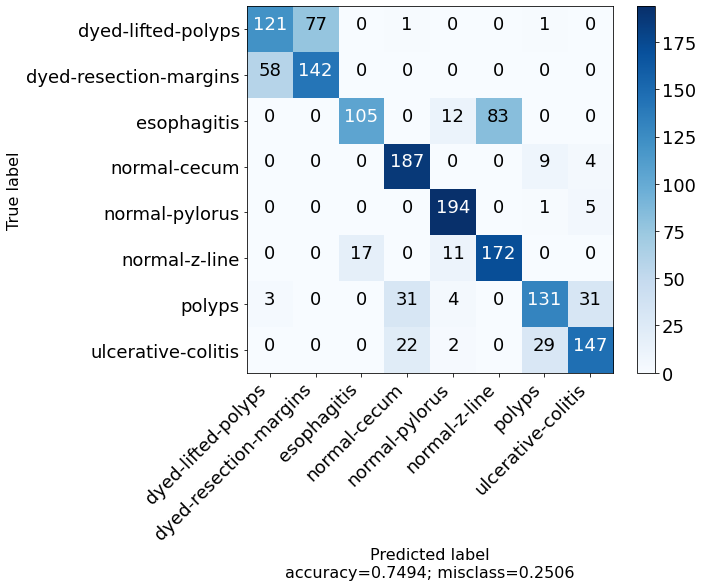

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        precision  recall  f1-score  support
dyed-lifted-polyps           0.66    0.60      0.63   200.00
dyed-resection-margins       0.65    0.71      0.68   200.00
esophagitis                  0.86    0.52      0.65   200.00
normal-cecum                 0.78    0.94      0.85   200.00
normal-pylorus               0.87    0.97      0.92   200.00
normal-z-line                0.67    0.86      0.76   200.00
polyps                       0.77    0.66      0.71   200.00
ulcerative-colitis           0.79    0.74      0.76   200.00
accuracy                     0.75    0.75      0.75     0.75
macro avg                    0.76    0.75      0.74  1600.00
weighted avg                 0.76    0.75      0.74  1600.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""

    Evaluate the prediction results.

    Displays a Confusion Matrix and a Classification Report.
    These are also saved to the 'results' folder.

"""
unique_labels = list(cnn_test_datagen.class_indices.keys())

y_pred = np.argmax(cnn_predictions, axis=-1)
y_true = cnn_test_datagen.classes[cnn_test_datagen.index_array]

display_confusion_matrix(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_simple/cnn_simple_confusion_matrix.png'
)

display_classification_report(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_simple/cnn_simple_classification_report.csv'
)

## 3 ResNet

### 3.1 Preprocessing

In [ ]:
"""

    Set up datagenerators for ResNet50 model

    Datagenerators handle image augmentation (shear, zoom, horizontal flips) as well as rescaling.
    They also have built-in utility to replicate ResNet's original preprocessing steps.
    The datagenerator also has a built-in training/validation splitter, which creates a new 80/20 split.

    In addition to that, we want a separate generator with our test set.

    The dataset will be split as follows:
    - Training set (64% - 80% of 80)
    - Validation set (16% - 20% of 80)
    - Test set (20%)

"""

"""
    Training set
"""
rn_train_idg = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # If defined, will split based on 'subset' in flow_from_directory()

rn_train_datagen = rn_train_idg.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    subset='training') # Marks this as the training data

rn_val_datagen = rn_train_idg.flow_from_directory(
    train_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    subset='validation') # Marks this as the validation data

"""
    Test set
"""
rn_test_idg = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)

rn_test_datagen = rn_test_idg.flow_from_directory(
    test_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False)

Found 5120 images belonging to 8 classes.
Found 1280 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


### 3.2 Build model

In [ ]:
"""
    Function to build the ResNet50 model
"""
def build_transfer_learning_model():
  
  # The ResNet50 is used as a base model
  base_model = keras.applications.resnet.ResNet50(include_top=False, 
                                                  weights='imagenet', 
                                                  input_shape=(target_w, target_h, target_dims))
  
  # We need our BatchNormalization layers to be trainable, the rest should be frozen
  for layer in base_model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  # Assemble our final model
  model = keras.models.Sequential([
                       base_model,
                       keras.layers.GlobalAveragePooling2D(),
                       keras.layers.Dropout(0.5),
                       keras.layers.Dense(8, activation="softmax")
  ])
  
  model.summary()

  return model

In [ ]:
"""

    Build and compile our ResNet50 model

    This model consists of frozen layers where only the BatchNormalization and output Dense layers are trainable.
    We will unfreeze and fine-tune the entire model later after the first fitting.
    
"""
rn_model = build_transfer_learning_model()

rn_model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ]
)

94773248/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
Total params: 23,604,104
Trainable params: 69,512
Non-trainable params: 23,534,592
_________________________________________________________________


### 3.3 Train model

In [ ]:
"""
    Start training our ResNet50 model

    This will also save the trained model file to our 'models' directory.
"""
rn_history = rn_model.fit(rn_train_datagen, 
                        epochs=30,
                        verbose=1, 
                        validation_data=rn_val_datagen)

rn_model.save('models/cnn_resnet_tl.hdf5')

if RunningInCOLAB:
    files.download('models/cnn_resnet_tl.hdf5')

Epoch 1/30
160/160 [==============================] - 183s 1s/step - loss: 2.0441 - accuracy: 0.2658 - val_loss: 1.2939 - val_accuracy: 0.5312
Epoch 2/30
160/160 [==============================] - 182s 1s/step - loss: 1.3266 - accuracy: 0.5033 - val_loss: 0.8722 - val_accuracy: 0.7273
Epoch 3/30
160/160 [==============================] - 184s 1s/step - loss: 1.0007 - accuracy: 0.6268 - val_loss: 0.6915 - val_accuracy: 0.7617
Epoch 4/30
160/160 [==============================] - 187s 1s/step - loss: 0.8341 - accuracy: 0.6834 - val_loss: 0.5851 - val_accuracy: 0.7977
Epoch 5/30
160/160 [==============================] - 189s 1s/step - loss: 0.7268 - accuracy: 0.7135 - val_loss: 0.5146 - val_accuracy: 0.8125
Epoch 6/30
160/160 [==============================] - 192s 1s/step - loss: 0.6338 - accuracy: 0.7533 - val_loss: 0.4806 - val_accuracy: 0.8195
Epoch 7/30
160/160 [==============================] - 191s 1s/step - loss: 0.5828 - accuracy: 0.7711 - val_loss: 0.4614 - val_accuracy: 0.8250

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

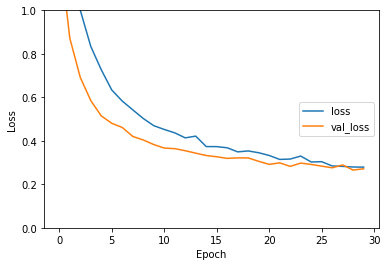

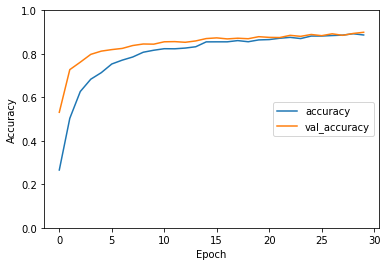

In [ ]:
"""

    Examine the training process

"""
plot_history(rn_history)

### 3.4 Evaluate model

In [ ]:
"""
    Use the model to predict on the unseen test set.
"""
rn_predictions = rn_model.predict(rn_test_datagen, verbose=1)

50/50 [==============================] - 25s 508ms/step


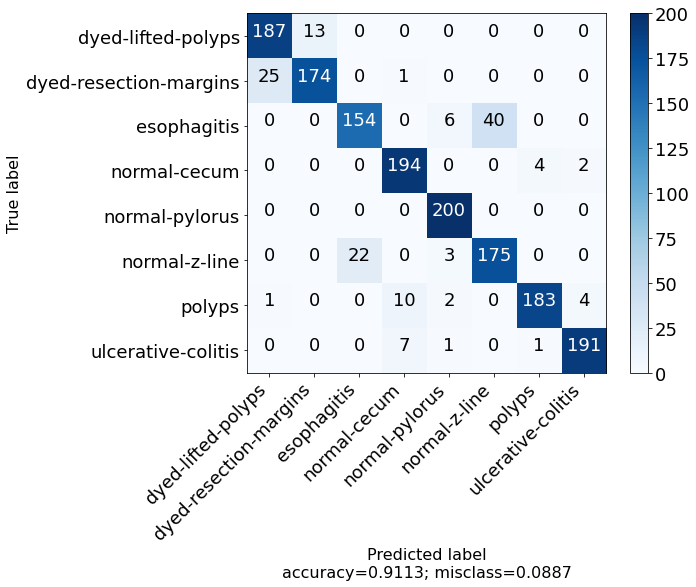

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        precision  recall  f1-score  support
dyed-lifted-polyps           0.88    0.94      0.91   200.00
dyed-resection-margins       0.93    0.87      0.90   200.00
esophagitis                  0.88    0.77      0.82   200.00
normal-cecum                 0.92    0.97      0.94   200.00
normal-pylorus               0.94    1.00      0.97   200.00
normal-z-line                0.81    0.88      0.84   200.00
polyps                       0.97    0.92      0.94   200.00
ulcerative-colitis           0.97    0.96      0.96   200.00
accuracy                     0.91    0.91      0.91     0.91
macro avg                    0.91    0.91      0.91  1600.00
weighted avg                 0.91    0.91      0.91  1600.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""

    Evaluate the prediction results.

    Displays a Confusion Matrix and a Classification Report.
    These are also saved to the 'results' folder.

"""
unique_labels = list(rn_test_datagen.class_indices.keys())

y_pred = np.argmax(rn_predictions, axis=-1)
y_true = rn_test_datagen.classes[rn_test_datagen.index_array]

display_confusion_matrix(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_resnet_tl/cnn_resnet_tl_confusion_matrix.png'
)

display_classification_report(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_resnet_tl/cnn_resnet_tl_classification_report.csv'
)

### 3.5 Unfreeze and re-train model

In [ ]:
"""
    Unfreeze all layers
"""
rn_model.trainable = True

"""
    Compile model with a lower learning rate
"""
rn_model.compile(
    optimizer=keras.optimizers.Adam(0.000001),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ],
)

"""
    Resume training
"""
rn_history_ft = rn_model.fit(rn_train_datagen, 
                        epochs=30,
                        verbose=1, 
                        validation_data=rn_val_datagen)


rn_model.save('models/cnn_resnet_tl_tuned.hdf5')

if RunningInCOLAB:
    files.download('models/cnn_resnet_tl_tuned.hdf5')

Epoch 1/30
160/160 [==============================] - 216s 1s/step - loss: 0.2675 - accuracy: 0.8998 - val_loss: 0.2713 - val_accuracy: 0.8914
Epoch 2/30
160/160 [==============================] - 212s 1s/step - loss: 0.2590 - accuracy: 0.8982 - val_loss: 0.2665 - val_accuracy: 0.8938
Epoch 3/30
160/160 [==============================] - 211s 1s/step - loss: 0.2532 - accuracy: 0.8992 - val_loss: 0.2552 - val_accuracy: 0.8977
Epoch 4/30
160/160 [==============================] - 209s 1s/step - loss: 0.2457 - accuracy: 0.9033 - val_loss: 0.2611 - val_accuracy: 0.8914
Epoch 5/30
160/160 [==============================] - 207s 1s/step - loss: 0.2346 - accuracy: 0.9070 - val_loss: 0.2611 - val_accuracy: 0.8867
Epoch 6/30
160/160 [==============================] - 206s 1s/step - loss: 0.2361 - accuracy: 0.9039 - val_loss: 0.2558 - val_accuracy: 0.8906
Epoch 7/30
160/160 [==============================] - 206s 1s/step - loss: 0.2279 - accuracy: 0.9117 - val_loss: 0.2549 - val_accuracy: 0.8984

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

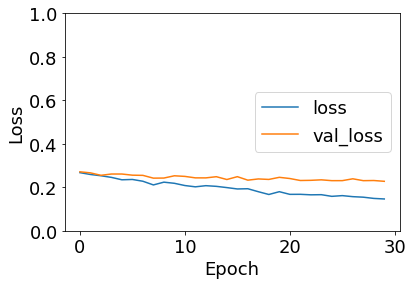

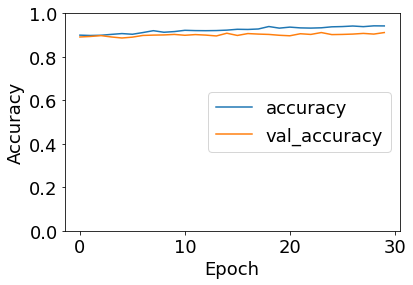

In [ ]:
"""

    Examine the training process

"""
plot_history(rn_history_ft)

### 3.6 Final model evaluation

In [ ]:
"""
    Use the model to predict on the unseen test set.
"""
rn_predictions = rn_model.predict(rn_test_datagen, verbose=1)

50/50 [==============================] - 26s 511ms/step


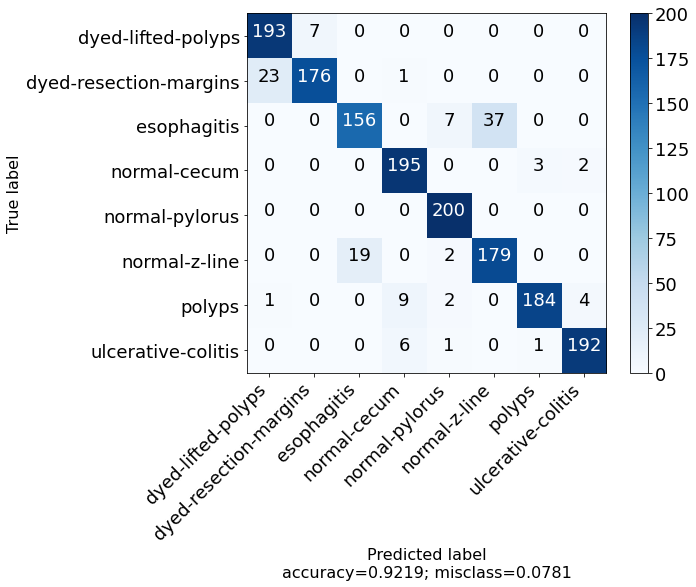

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        precision  recall  f1-score  support
dyed-lifted-polyps           0.89    0.96      0.93   200.00
dyed-resection-margins       0.96    0.88      0.92   200.00
esophagitis                  0.89    0.78      0.83   200.00
normal-cecum                 0.92    0.98      0.95   200.00
normal-pylorus               0.94    1.00      0.97   200.00
normal-z-line                0.83    0.90      0.86   200.00
polyps                       0.98    0.92      0.95   200.00
ulcerative-colitis           0.97    0.96      0.96   200.00
accuracy                     0.92    0.92      0.92     0.92
macro avg                    0.92    0.92      0.92  1600.00
weighted avg                 0.92    0.92      0.92  1600.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""

    Evaluate the prediction results.

    Displays a Confusion Matrix and a Classification Report.
    These are also saved to the 'results' folder.

"""
unique_labels = list(rn_test_datagen.class_indices.keys())

y_pred = np.argmax(rn_predictions, axis=-1)
y_true = rn_test_datagen.classes[rn_test_datagen.index_array]

display_confusion_matrix(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_resnet_tl_tuned/cnn_resnet_tl_tuned_confusion_matrix.png'
)

display_classification_report(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_resnet_tl_tuned/cnn_resnet_tl_tuned_classification_report.csv'
)